# Late Fusion Model with EEG + Normalized Modalities

This notebook implements **weighted late fusion** combining:
- **Physiological data** (pupil metrics) - normalized with StandardScaler
- **Behavioral data** (reaction time, decision time, etc.) - normalized with StandardScaler
- **Gaze data** (gaze position, movements, fixations) - normalized with StandardScaler
- **EEG data** (band power features) - normalized with StandardScaler

**Note**: 
- EEG data is only available for **10 subjects**, so this analysis is limited to those subjects
- Separate EEG files for PRE and POST timeframes

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

**Key Change**: Uses **Logistic Regression** as base models instead of Random Forest.
- Logistic Regression is sensitive to feature scaling, so normalization matters
- Random Forest is scale-invariant (tree-based splits don't depend on magnitude)

Goals:
1. Load and merge EEG features with other modalities (matched by subject and trial)
2. Normalize all modality features with StandardScaler
3. Train separate Logistic Regression models for each modality
4. Implement weighted late fusion
5. Extract weights to estimate modality influence on predictions

In [15]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
# ============================================================================

import sys
sys.path.append('../../..')  # Add project root to path

import json
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, signal
import warnings
warnings.filterwarnings('ignore')

# Import from src package
from src.utils.io import load_features, save_results
from src.utils.config import get_model_params, load_config
from src.utils.validation import validate_features, validate_modality_features
from src.visualization.plots import (
    plot_method_comparison,
    plot_modality_weights,
    set_style
)

np.random.seed(42)
set_style('whitegrid')  # Use shared style function

print(f"\n{'='*70}")
print(f"LATE FUSION WITH EEG: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


LATE FUSION WITH EEG: PRE-DECISION PERIOD



## 1. Load Pre-Extracted Features (All Modalities)

In [16]:
# Load configuration
config = load_config('model_params')
time_window = config['time_windows'][f'{TIMEFRAME.lower()}_decision']

print(f"Time window: {time_window['start']}s to {time_window['end']}s")
print(f"Description: {time_window['description']}\n")

# Load pre-extracted features (physio, behavior, gaze)
features_path = f'../../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl'
feature_data = load_features(features_path, timeframe=TIMEFRAME)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"\nFeature counts:")
print(f"  Physiology ({TIMEFRAME}): {len(physio_cols)} features")
print(f"  Behavior: {len(behavior_cols)} features")
print(f"  Gaze: {len(gaze_cols)} features")

Time window: -2.0s to 0.0s
Description: Anticipatory period before submit button

Loaded 12511 trials from 97 subjects

Feature counts:
  Physiology (PRE): 13 features
  Behavior: 7 features
  Gaze: 20 features


## 2. Load and Extract EEG Features

In [27]:
# EEG feature extraction parameters
freq_bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 50)
}

channel_names = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
    'T3', 'C3', 'Cz', 'C4', 'T4',
    'T5', 'P3', 'Pz', 'P4', 'T6',
    'O1', 'Oz', 'O2'
]

channel_regions = {
    'Frontal': ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8'],
    'Central': ['T3', 'C3', 'Cz', 'C4', 'T4'],
    'Parietal': ['T5', 'P3', 'Pz', 'P4', 'T6'],
    'Occipital': ['O1', 'Oz', 'O2']
}

def compute_band_power(eeg_data, fs=256, bands=None):
    """Compute band power for each channel and frequency band."""
    if bands is None:
        bands = freq_bands
    
    freqs, psd = signal.welch(eeg_data, fs=fs, nperseg=min(256, eeg_data.shape[1]))
    
    band_powers = {}
    for band_name, (f_low, f_high) in bands.items():
        freq_mask = (freqs >= f_low) & (freqs <= f_high)
        band_power = np.trapz(psd[:, freq_mask], freqs[freq_mask], axis=1)
        band_powers[band_name] = band_power
    
    return band_powers

def extract_eeg_features(eeg_df, fs=256):
    """Extract band power features for all trials.
    
    Note: review_eeg is already baseline-corrected, so we use it directly.
    """
    features_list = []
    
    for idx, row in eeg_df.iterrows():
        # review_eeg is already baseline-corrected
        review_eeg = np.array(row['review_eeg'])
        
        # Compute band powers directly on baseline-corrected data
        bp_review = compute_band_power(review_eeg, fs)
        
        # Create composite trial_id to match extracted_features format
        trial_features = {
            'subject_id': row['subject_date_id'],
            'trial_id': f"{row['trial_id']}_{row['subject_date_id']}"
        }
        
        for band_name in freq_bands.keys():
            band_power = bp_review[band_name]
            
            # Average by region
            for region, channels in channel_regions.items():
                ch_indices = [channel_names.index(ch) for ch in channels]
                avg_power = np.mean(band_power[ch_indices])
                trial_features[f'eeg_{band_name}_{region}'] = avg_power
        
        features_list.append(trial_features)
    
    return pd.DataFrame(features_list)

# Load preprocessed EEG data (10 subjects) - use correct file based on TIMEFRAME
eeg_file = f'../../../data/eeg/preprocessed_eeg_10_subjects_{TIMEFRAME.lower()}.pkl'
print(f"Loading EEG data from: {eeg_file}")
with open(eeg_file, 'rb') as f:
    eeg_raw_df = pickle.load(f)

print(f"Loaded {len(eeg_raw_df)} EEG trials from {eeg_raw_df['subject_date_id'].nunique()} subjects")

# Extract EEG features
print("\nExtracting EEG features (using baseline-corrected review_eeg)...")
eeg_features_df = extract_eeg_features(eeg_raw_df, fs=256)
eeg_cols = [c for c in eeg_features_df.columns if c.startswith('eeg_')]

print(f"Extracted {len(eeg_cols)} EEG features")
print(f"EEG subjects: {eeg_features_df['subject_id'].unique()}")

Loading EEG data from: ../../../data/eeg/preprocessed_eeg_10_subjects_pre.pkl
Loaded 1287 EEG trials from 10 subjects

Extracting EEG features (using baseline-corrected review_eeg)...
Extracted 20 EEG features
EEG subjects: ['0831_1300_9M4VCHG' '0811_1000_U9TEJGM' '0831_1300_539136F'
 '0825_1300_539136F' '0825_1300_9M4VCHG' '0923_1000_U9TEJGM'
 '0824_1000_U9TEJGM' '0920_1600_U9TEJGM' '0818_1600_539136F'
 '0818_1600_9M4VCHG']


## 3. Merge Features and Filter to EEG Subjects

In [18]:
# Get EEG subjects
eeg_subjects = eeg_features_df['subject_id'].unique()
print(f"EEG subjects ({len(eeg_subjects)}): {eeg_subjects}")

# Filter merged_df to only EEG subjects
merged_df_eeg = merged_df[merged_df['subject_id'].isin(eeg_subjects)].copy()
print(f"\nFiltered to EEG subjects: {len(merged_df_eeg)} trials")

# Merge with EEG features on trial_id
merged_df_eeg = merged_df_eeg.merge(
    eeg_features_df[['trial_id'] + eeg_cols],
    on='trial_id',
    how='inner'
)

print(f"After merging with EEG: {len(merged_df_eeg)} trials")
print(f"Subjects: {merged_df_eeg['subject_id'].nunique()}")
print(f"Trials per subject: {merged_df_eeg.groupby('subject_id').size().to_dict()}")

# Check outcome balance
outcome_counts = merged_df_eeg['outcome'].value_counts()
print(f"\nOutcome balance: {outcome_counts.get(0, 0)} keep / {outcome_counts.get(1, 0)} invest")

EEG subjects (10): ['0831_1300_9M4VCHG' '0811_1000_U9TEJGM' '0831_1300_539136F'
 '0825_1300_539136F' '0825_1300_9M4VCHG' '0923_1000_U9TEJGM'
 '0824_1000_U9TEJGM' '0920_1600_U9TEJGM' '0818_1600_539136F'
 '0818_1600_9M4VCHG']

Filtered to EEG subjects: 1210 trials
After merging with EEG: 1173 trials
Subjects: 10
Trials per subject: {'0811_1000_U9TEJGM': 121, '0818_1600_539136F': 132, '0818_1600_9M4VCHG': 89, '0824_1000_U9TEJGM': 113, '0825_1300_539136F': 124, '0825_1300_9M4VCHG': 112, '0831_1300_539136F': 129, '0831_1300_9M4VCHG': 118, '0920_1600_U9TEJGM': 115, '0923_1000_U9TEJGM': 120}

Outcome balance: 389 keep / 784 invest


## 4. Prepare and Normalize Feature Sets

**Normalization Strategy:**
- **Physiology**: StandardScaler normalization
- **Behavior**: StandardScaler normalization
- **Gaze**: StandardScaler normalization
- **EEG**: StandardScaler normalization

All modalities are normalized because Logistic Regression is sensitive to feature scaling.

In [19]:
# Prepare feature arrays - ALL modalities normalized for Logistic Regression

# Physiology: Impute then normalize
X_physio_imputed = SimpleImputer(strategy='mean').fit_transform(merged_df_eeg[physio_cols])
scaler_physio = StandardScaler()
X_physio = scaler_physio.fit_transform(X_physio_imputed)

# Behavior: Impute then normalize
X_behavior_imputed = SimpleImputer(strategy='mean').fit_transform(merged_df_eeg[behavior_cols])
scaler_behavior = StandardScaler()
X_behavior = scaler_behavior.fit_transform(X_behavior_imputed)

# Gaze: Impute then normalize (if available)
if len(gaze_cols) > 0:
    X_gaze_imputed = SimpleImputer(strategy='mean').fit_transform(merged_df_eeg[gaze_cols])
    scaler_gaze = StandardScaler()
    X_gaze = scaler_gaze.fit_transform(X_gaze_imputed)
else:
    X_gaze = np.zeros((len(merged_df_eeg), 1))

# EEG: Impute then normalize
X_eeg_imputed = SimpleImputer(strategy='mean').fit_transform(merged_df_eeg[eeg_cols])
scaler_eeg = StandardScaler()
X_eeg = scaler_eeg.fit_transform(X_eeg_imputed)

y = merged_df_eeg['outcome'].values
subjects = merged_df_eeg['subject_id'].values

print(f"Shapes after normalization:")
print(f"  X_physio (normalized):   {X_physio.shape}")
print(f"  X_behavior (normalized): {X_behavior.shape}")
print(f"  X_gaze (normalized):     {X_gaze.shape}")
print(f"  X_eeg (normalized):      {X_eeg.shape}")

# Verify normalization
print(f"\nNormalization check (mean ≈ 0, std ≈ 1):")
print(f"  Physiology mean: {X_physio.mean():.4f}, std: {X_physio.std():.4f}")
print(f"  Behavior mean:   {X_behavior.mean():.4f}, std: {X_behavior.std():.4f}")
if len(gaze_cols) > 0:
    print(f"  Gaze mean:       {X_gaze.mean():.4f}, std: {X_gaze.std():.4f}")
print(f"  EEG mean:        {X_eeg.mean():.4f}, std: {X_eeg.std():.4f}")

Shapes after normalization:
  X_physio (normalized):   (1173, 13)
  X_behavior (normalized): (1173, 7)
  X_gaze (normalized):     (1173, 20)
  X_eeg (normalized):      (1173, 20)

Normalization check (mean ≈ 0, std ≈ 1):
  Physiology mean: -0.0000, std: 1.0000
  Behavior mean:   -0.0000, std: 1.0000
  Gaze mean:       0.0000, std: 0.9747
  EEG mean:        0.0000, std: 1.0000


In [20]:
def train_evaluate_modality(X, y, subjects, modality_name):
    """
    Train and evaluate a single modality using LOSO cross-validation.
    Uses Logistic Regression (scale-sensitive) instead of Random Forest.
    """
    logo = LeaveOneGroupOut()
    
    # Initialize storage
    all_preds = []
    all_y_true = []
    subject_accs = []
    subject_f1s = []
    
    print(f"\n{'='*50}")
    print(f"{modality_name} Model (Logistic Regression, Normalized)")
    print(f"{'='*50}")
    
    # LOSO cross-validation
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train Logistic Regression model (scale-sensitive!)
        model = LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=42,
            solver='lbfgs'
        )
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Store results
        all_preds.extend(y_pred)
        all_y_true.extend(y_test)
        
        # Subject-level metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        subject_accs.append(acc)
        subject_f1s.append(f1)
    
    # Calculate overall metrics
    overall_acc = np.mean(subject_accs)
    overall_f1 = np.mean(subject_f1s)
    
    print(f"Accuracy: {overall_acc:.3f} ± {stats.sem(subject_accs):.3f}")
    print(f"F1-Score: {overall_f1:.3f} ± {stats.sem(subject_f1s):.3f}")
    print(f"N subjects: {len(subject_accs)}")
    
    return model, overall_acc, overall_f1, np.array(all_preds), np.array(all_y_true)

## 5. Train Individual Modality Models

In [21]:
model_physio, acc_physio, f1_physio, pred_physio, y_true = train_evaluate_modality(
    X_physio, y, subjects, "Physiology"
)
model_behavior, acc_behavior, f1_behavior, pred_behavior, _ = train_evaluate_modality(
    X_behavior, y, subjects, "Behavior"
)

# Train gaze model if gaze data exists
if len(gaze_cols) > 0:
    model_gaze, acc_gaze, f1_gaze, pred_gaze, _ = train_evaluate_modality(
        X_gaze, y, subjects, "Gaze"
    )
else:
    model_gaze = None
    acc_gaze = 0.5
    f1_gaze = 0.5
    pred_gaze = np.zeros(len(y))
    print(f"\n{'='*50}\nGaze Model\n{'='*50}")
    print("Skipping - no gaze data available (POST condition)")

# Train EEG model
model_eeg, acc_eeg, f1_eeg, pred_eeg, _ = train_evaluate_modality(
    X_eeg, y, subjects, "EEG"
)


Physiology Model (Logistic Regression, Normalized)
Accuracy: 0.528 ± 0.029
F1-Score: 0.524 ± 0.027
N subjects: 10

Behavior Model (Logistic Regression, Normalized)
Accuracy: 0.692 ± 0.046
F1-Score: 0.704 ± 0.043
N subjects: 10

Gaze Model (Logistic Regression, Normalized)
Accuracy: 0.556 ± 0.041
F1-Score: 0.504 ± 0.044
N subjects: 10

EEG Model (Logistic Regression, Normalized)
Accuracy: 0.595 ± 0.046
F1-Score: 0.505 ± 0.054
N subjects: 10


## 6. Weighted Late Fusion Implementation

Custom implementation using **Logistic Regression** as base models (scale-sensitive) instead of Random Forest.

In [22]:
def weighted_late_fusion_logreg(X_modalities, y, subjects, modality_names):
    """
    Weighted late fusion using Logistic Regression base models.
    This is scale-sensitive, so normalization matters!
    """
    logo = LeaveOneGroupOut()
    
    # Store subject-level results
    subject_accs = {}
    subject_f1s = {}
    all_weights = []
    preds_all = []
    y_true_all = []
    
    # LOSO cross-validation
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        y_train, y_test = y[train_idx], y[test_idx]
        train_subjects = subjects[train_idx]
        
        # Get out-of-fold predictions for meta-learner training
        train_probs = np.zeros((len(train_idx), len(X_modalities)))
        
        # Nested k-fold within training set (use min of 5 or n_subjects-1)
        n_inner_splits = min(5, len(np.unique(train_subjects)) - 1)
        if n_inner_splits < 2:
            n_inner_splits = 2
        
        gkf_inner = GroupKFold(n_splits=n_inner_splits)
        for inner_train_idx, inner_val_idx in gkf_inner.split(
            X_modalities[0][train_idx], y_train, train_subjects
        ):
            abs_inner_train = train_idx[inner_train_idx]
            abs_inner_val = train_idx[inner_val_idx]
            
            # Train Logistic Regression base models
            for mod_i, X in enumerate(X_modalities):
                model = LogisticRegression(
                    max_iter=1000,
                    class_weight='balanced',
                    random_state=42
                )
                model.fit(X[abs_inner_train], y[abs_inner_train])
                train_probs[inner_val_idx, mod_i] = model.predict_proba(X[abs_inner_val])[:, 1]
        
        # Train base models on full training set and get test predictions
        test_probs = []
        for X in X_modalities:
            X_train, X_test = X[train_idx], X[test_idx]
            model = LogisticRegression(
                max_iter=1000,
                class_weight='balanced',
                random_state=42
            )
            model.fit(X_train, y_train)
            test_probs.append(model.predict_proba(X_test)[:, 1])
        
        test_probs = np.column_stack(test_probs)
        
        # Meta-learner (Logistic Regression)
        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(train_probs, y_train)
        weights = meta.coef_[0]
        y_pred = meta.predict(test_probs)
        
        # Store subject-level metrics
        test_subject = subjects[test_idx][0]
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        subject_accs[test_subject] = acc
        subject_f1s[test_subject] = f1
        all_weights.append(weights)
        preds_all.extend(y_pred)
        y_true_all.extend(y_test)
    
    # Average and normalize weights
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))  # Softmax
    
    subject_acc_values = np.array(list(subject_accs.values()))
    subject_f1_values = np.array(list(subject_f1s.values()))
    
    return {
        'accuracy_mean': np.mean(subject_acc_values),
        'accuracy_sem': stats.sem(subject_acc_values),
        'f1_mean': np.mean(subject_f1_values),
        'f1_sem': stats.sem(subject_f1_values),
        'weights': norm_weights,
        'n_subjects': len(subject_accs),
        'n_trials': len(y),
        'subject_accs': subject_accs,
        'subject_f1s': subject_f1s
    }

# Prepare modality lists (include EEG)
if len(gaze_cols) > 0:
    X_modalities = [X_physio, X_behavior, X_gaze, X_eeg]
    modality_names = ['Physiology', 'Behavior', 'Gaze', 'EEG']
else:
    X_modalities = [X_physio, X_behavior, X_eeg]
    modality_names = ['Physiology', 'Behavior', 'EEG']

print(f"\nModalities for fusion: {modality_names}")
for name, X in zip(modality_names, X_modalities):
    print(f"  {name}: {X.shape}")

print("\nRunning weighted late fusion with Logistic Regression base models...")
print("(Normalization now matters because LR is scale-sensitive!)\n")
results_weighted = weighted_late_fusion_logreg(X_modalities, y, subjects, modality_names)

print(f"\n{'='*50}")
print("WEIGHTED FUSION RESULTS (Logistic Regression)")
print(f"{'='*50}")
print(f"Accuracy: {results_weighted['accuracy_mean']:.3f} ± {results_weighted['accuracy_sem']:.3f}")
print(f"F1-Score: {results_weighted['f1_mean']:.3f} ± {results_weighted['f1_sem']:.3f}")
print(f"N Subjects: {results_weighted['n_subjects']}")
print(f"N Trials: {results_weighted['n_trials']}")


Modalities for fusion: ['Physiology', 'Behavior', 'Gaze', 'EEG']
  Physiology: (1173, 13)
  Behavior: (1173, 7)
  Gaze: (1173, 20)
  EEG: (1173, 20)

Running weighted late fusion with Logistic Regression base models...
(Normalization now matters because LR is scale-sensitive!)


WEIGHTED FUSION RESULTS (Logistic Regression)
Accuracy: 0.681 ± 0.030
F1-Score: 0.647 ± 0.033
N Subjects: 10
N Trials: 1173


## 7. Results Summary


PERFORMANCE COMPARISON (PRE) - WITH EEG (10 subjects)
                          Method  Accuracy  F1-Score
                 Physiology Only  0.528433  0.523747
                   Behavior Only  0.692138  0.704082
                       Gaze Only  0.556233  0.504070
                        EEG Only  0.595451  0.504622
Weighted Fusion (All Modalities)  0.680605  0.646581


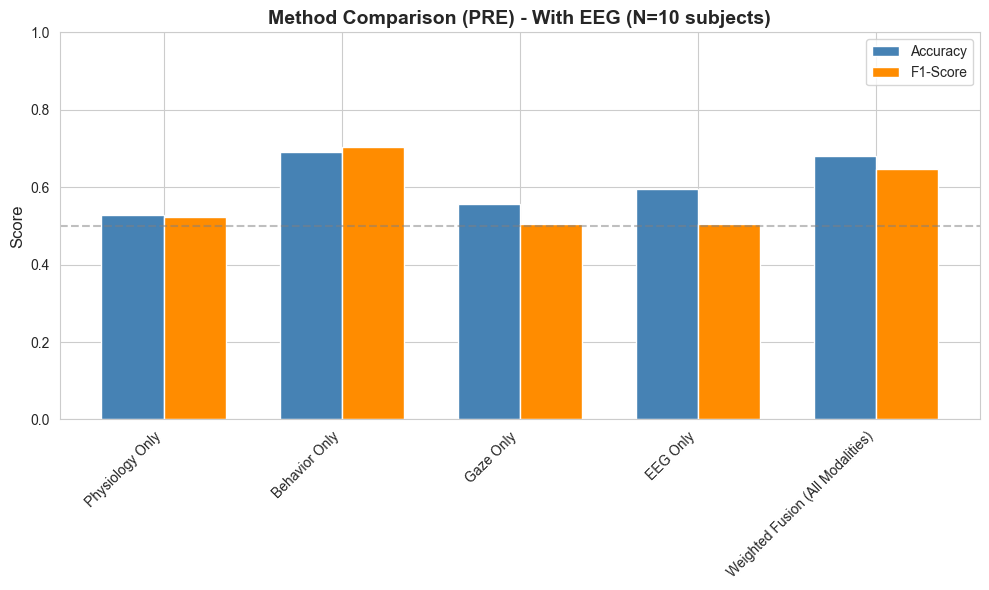

In [23]:
# Build comparison dataframe
comparison_data = {
    'Method': ['Physiology Only', 'Behavior Only'],
    'Accuracy': [acc_physio, acc_behavior],
    'F1-Score': [f1_physio, f1_behavior]
}

# Add gaze if available
if len(gaze_cols) > 0:
    comparison_data['Method'].append('Gaze Only')
    comparison_data['Accuracy'].append(acc_gaze)
    comparison_data['F1-Score'].append(f1_gaze)

# Add EEG
comparison_data['Method'].append('EEG Only')
comparison_data['Accuracy'].append(acc_eeg)
comparison_data['F1-Score'].append(f1_eeg)

# Add weighted fusion
comparison_data['Method'].append('Weighted Fusion (All Modalities)')
comparison_data['Accuracy'].append(results_weighted['accuracy_mean'])
comparison_data['F1-Score'].append(results_weighted['f1_mean'])

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print(f"PERFORMANCE COMPARISON ({TIMEFRAME}) - WITH EEG (10 subjects)")
print("="*70)
print(comparison_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Accuracy'], width, label='Accuracy', color='steelblue')
bars2 = ax.bar(x + width/2, comparison_df['F1-Score'], width, label='F1-Score', color='darkorange')

ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Method Comparison ({TIMEFRAME}) - With EEG (N=10 subjects)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Method'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Chance')

plt.tight_layout()
plt.show()

## 8. Modality Contribution Analysis


MODALITY CONTRIBUTIONS (Weighted Fusion)
  Modality   Weight  Percentage
Physiology 0.031519    3.151935
  Behavior 0.854684   85.468416
      Gaze 0.043583    4.358333
       EEG 0.070213    7.021317


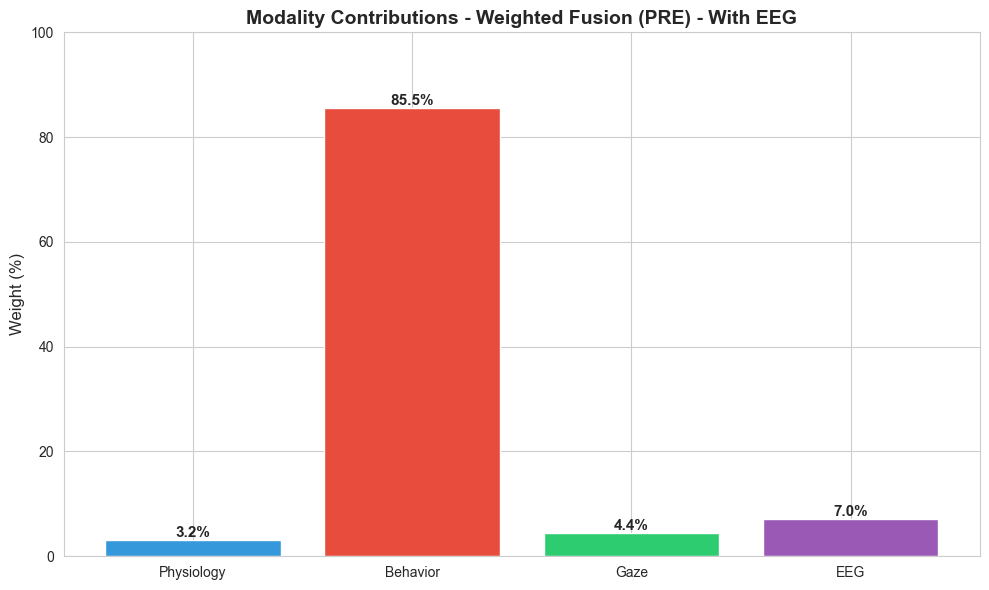

In [24]:
# Create weights dataframe
weights_df = pd.DataFrame({
    'Modality': modality_names,
    'Weight': results_weighted['weights'],
    'Percentage': results_weighted['weights'] * 100
})

print("\n" + "="*50)
print("MODALITY CONTRIBUTIONS (Weighted Fusion)")
print("="*50)
print(weights_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'][:len(modality_names)]
bars = ax.bar(weights_df['Modality'], weights_df['Percentage'], color=colors)
ax.set_ylabel('Weight (%)', fontsize=12)
ax.set_title(f'Modality Contributions - Weighted Fusion ({TIMEFRAME}) - With EEG', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Summary Statistics

In [25]:
print("\n" + "="*70)
print(f"SUMMARY ({TIMEFRAME}-DECISION) - WITH EEG (10 subjects)")
print("="*70)

print("\n1. INDIVIDUAL MODALITIES (Logistic Regression, all normalized):")
print(f"   Physiology:  Acc={acc_physio:.3f}, F1={f1_physio:.3f}")
print(f"   Behavior:    Acc={acc_behavior:.3f}, F1={f1_behavior:.3f}")
if len(gaze_cols) > 0:
    print(f"   Gaze:        Acc={acc_gaze:.3f}, F1={f1_gaze:.3f}")
else:
    print(f"   Gaze:        Not available (POST condition)")
print(f"   EEG:         Acc={acc_eeg:.3f}, F1={f1_eeg:.3f}")

print("\n2. WEIGHTED LATE FUSION (Logistic Regression base models):")
print(f"   Accuracy:    {results_weighted['accuracy_mean']:.3f} ± {results_weighted['accuracy_sem']:.3f}")
print(f"   F1-Score:    {results_weighted['f1_mean']:.3f} ± {results_weighted['f1_sem']:.3f}")
print(f"   N Subjects:  {results_weighted['n_subjects']}")
print(f"   N Trials:    {results_weighted['n_trials']}")

print("\n3. MODALITY CONTRIBUTIONS:")
for name, w in zip(modality_names, results_weighted['weights']):
    print(f"   {name:12s}: {w*100:5.1f}%")

best = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
print(f"\n4. BEST METHOD: {best['Method']} (Acc={best['Accuracy']:.3f})")

print("\nNote: This analysis uses only 10 subjects (those with EEG data).")
print("      Results may differ from full-sample analysis.")
print("\n" + "="*70)


SUMMARY (PRE-DECISION) - WITH EEG (10 subjects)

1. INDIVIDUAL MODALITIES (Logistic Regression, all normalized):
   Physiology:  Acc=0.528, F1=0.524
   Behavior:    Acc=0.692, F1=0.704
   Gaze:        Acc=0.556, F1=0.504
   EEG:         Acc=0.595, F1=0.505

2. WEIGHTED LATE FUSION (Logistic Regression base models):
   Accuracy:    0.681 ± 0.030
   F1-Score:    0.647 ± 0.033
   N Subjects:  10
   N Trials:    1173

3. MODALITY CONTRIBUTIONS:
   Physiology  :   3.2%
   Behavior    :  85.5%
   Gaze        :   4.4%
   EEG         :   7.0%

4. BEST METHOD: Behavior Only (Acc=0.692)

Note: This analysis uses only 10 subjects (those with EEG data).
      Results may differ from full-sample analysis.



## 10. Save Results

In [26]:
# Save results
import os
output_dir = f'../../../data/results/fusion_model_with_eeg_{TIMEFRAME}'
os.makedirs(output_dir, exist_ok=True)

# 1. Save method comparison results
save_results(comparison_df, 
             f'{output_dir}/late_fusion_with_eeg_{TIMEFRAME}_method_comparison.csv')

# 2. Save modality weights
save_results(weights_df,
             f'{output_dir}/late_fusion_with_eeg_{TIMEFRAME}_modality_weights.csv')

# 3. Save weighted fusion summary
weighted_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Accuracy_SEM', 'F1_Score', 'F1_SEM', 'N_Subjects', 'N_Trials', 'Base_Model'],
    'Value': [
        results_weighted['accuracy_mean'],
        results_weighted['accuracy_sem'],
        results_weighted['f1_mean'],
        results_weighted['f1_sem'],
        results_weighted['n_subjects'],
        results_weighted['n_trials'],
        'LogisticRegression'
    ]
})
save_results(weighted_summary,
             f'{output_dir}/late_fusion_with_eeg_{TIMEFRAME}_weighted_fusion_summary.csv')

# 4. Save subject-level accuracies
subject_df = pd.DataFrame({
    'subject_id': list(results_weighted['subject_accs'].keys()),
    'accuracy': list(results_weighted['subject_accs'].values())
})
save_results(subject_df,
             f'{output_dir}/late_fusion_with_eeg_{TIMEFRAME}_subject_accuracies.csv')
print(f"  - {len(subject_df)} subjects, Mean accuracy: {subject_df['accuracy'].mean():.4f}")

# 5. Save modality info
modality_info = pd.DataFrame({
    'Modality': modality_names,
    'N_Features': [X_physio.shape[1], X_behavior.shape[1]] + 
                  ([X_gaze.shape[1]] if len(gaze_cols) > 0 else []) + 
                  [X_eeg.shape[1]],
    'Normalized': ['Yes (StandardScaler)'] * len(modality_names),
    'Base_Model': ['LogisticRegression'] * len(modality_names)
})
save_results(modality_info,
             f'{output_dir}/late_fusion_with_eeg_{TIMEFRAME}_modality_info.csv')

print(f"\n✓ All results saved to: {output_dir}/")

✓ Saved results to: ../../../data/results/fusion_model_with_eeg_PRE/late_fusion_with_eeg_PRE_method_comparison.csv
✓ Saved results to: ../../../data/results/fusion_model_with_eeg_PRE/late_fusion_with_eeg_PRE_modality_weights.csv
✓ Saved results to: ../../../data/results/fusion_model_with_eeg_PRE/late_fusion_with_eeg_PRE_weighted_fusion_summary.csv
✓ Saved results to: ../../../data/results/fusion_model_with_eeg_PRE/late_fusion_with_eeg_PRE_subject_accuracies.csv
  - 10 subjects, Mean accuracy: 0.6806
✓ Saved results to: ../../../data/results/fusion_model_with_eeg_PRE/late_fusion_with_eeg_PRE_modality_info.csv

✓ All results saved to: ../../../data/results/fusion_model_with_eeg_PRE/
